In [1]:
# Author Bereket Kebede, Graduate Student
# Neural Networks -  Assignment #5 - University of Memphis. Fall 2021
# Question #2, Convolutional Variational Auto-Encoder (VAE)
# Last updated - Nov 23, 2021 
# https://www.kaggle.com/tarunkr/autoencoder-denoising-image-mnist-cifar10/notebook

In [2]:
#####################################################################################
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D
from keras.models import Model
from keras.datasets import cifar10
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [3]:
#####################################################################################
# Load Data

(cifar_train, _), (cifar_test, _) = cifar10.load_data()

size = 32
channel = 3
# scaling input data
cifar_train = cifar_train / 255
cifar_test = cifar_test / 255

# Adding noise mean = 0, std = 0.3
noise = 0.3
cifar_train_noise = cifar_train + noise * np.random.normal(0, 0.3, size=cifar_train.shape) 
cifar_test_noise = cifar_test + noise * np.random.normal(0, 0.3, size=cifar_test.shape)

cifar_train_noise = np.clip(cifar_train_noise, 0, 1)
cifar_test_noise = np.clip(cifar_test_noise, 0, 1)

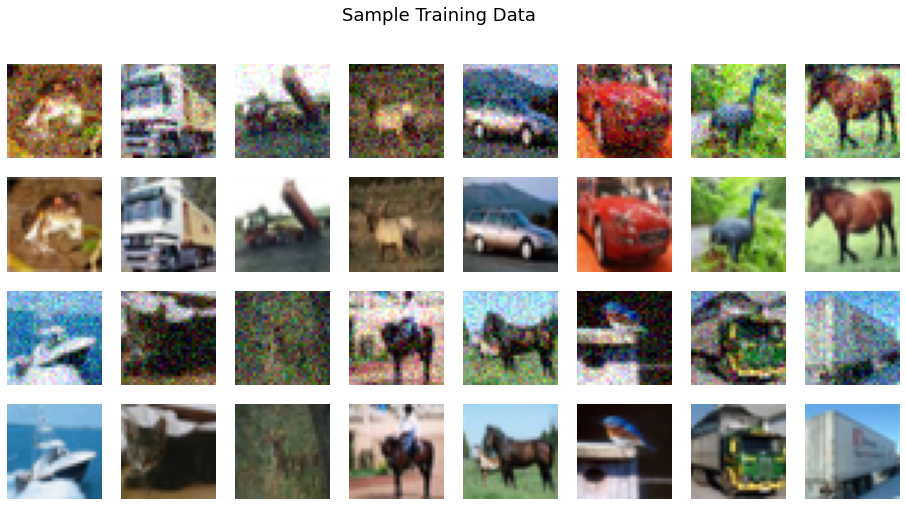

In [4]:
#####################################################################################
# Visualize sample training images with their noisy images

rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train_noise[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data",fontsize=18)
plt.savefig("Cifar-train.png")

plt.show()

In [6]:
#####################################################################################
# Build Encoder 
inputs = Input(shape=(size,size,channel))

x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
x = LeakyReLU()(skip)
x = BatchNormalization()(x)
x = MaxPool2D()(x)
x = Dropout(0.5)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPool2D()(x)

#####################################################################################
# Build Decoder
x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2DTranspose(32, 3, padding='same')(x)
x = add([x,skip]) # adding skip connection
x = LeakyReLU()(x)
x = BatchNormalization()(x)
decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['batch_normalization[0][0]']

In [7]:
#####################################################################################
# Train the network

epochs = 25
batch_size = 256

history = autoencoder.fit(cifar_train_noise,
                cifar_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(cifar_test_noise, cifar_test)
               )

Epoch 1/25
196/196 [==============================] - 6s 16ms/step - loss: 0.5803 - val_loss: 0.6060
Epoch 2/25
196/196 [==============================] - 3s 13ms/step - loss: 0.5616 - val_loss: 0.5765
Epoch 3/25
196/196 [==============================] - 3s 13ms/step - loss: 0.5599 - val_loss: 0.5629
Epoch 4/25
196/196 [==============================] - 3s 13ms/step - loss: 0.5590 - val_loss: 0.5581
Epoch 5/25
196/196 [==============================] - 3s 13ms/step - loss: 0.5585 - val_loss: 0.5570
Epoch 6/25
196/196 [==============================] - 3s 13ms/step - loss: 0.5581 - val_loss: 0.5567
Epoch 7/25
196/196 [==============================] - ETA: 0s - loss: 0.5579- ETA: 0s - loss - ETA: 0s - loss: 0. - 3s 13ms/step - loss: 0.5579 - val_loss: 0.5556
Epoch 8/25
196/196 [==============================] - 3s 13ms/step - loss: 0.5577 - val_loss: 0.5555
Epoch 9/25
196/196 [==============================] - 3s 14ms/step - loss: 0.5575 - val_loss: 0.5557
Epoch 10/25
196/196 [========

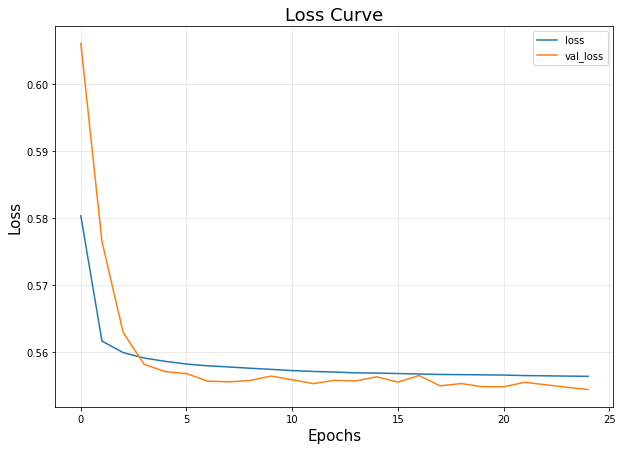

In [8]:
#####################################################################################
# Plot loss function

# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(history.epoch, history.history['loss'], label = "loss") # Loss curve for training set
plt.plot(history.epoch, history.history['val_loss'], label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve_cifar10.png")
plt.show()

In [9]:
#####################################################################################
# Select few random test images
num_imgs = 48
rand = np.random.randint(1, cifar_test_noise.shape[0]-48) 

cifar_test_images = cifar_test_noise[rand:rand+num_imgs] # slicing
cifar_test_desoided = autoencoder.predict(cifar_test_images) # predict

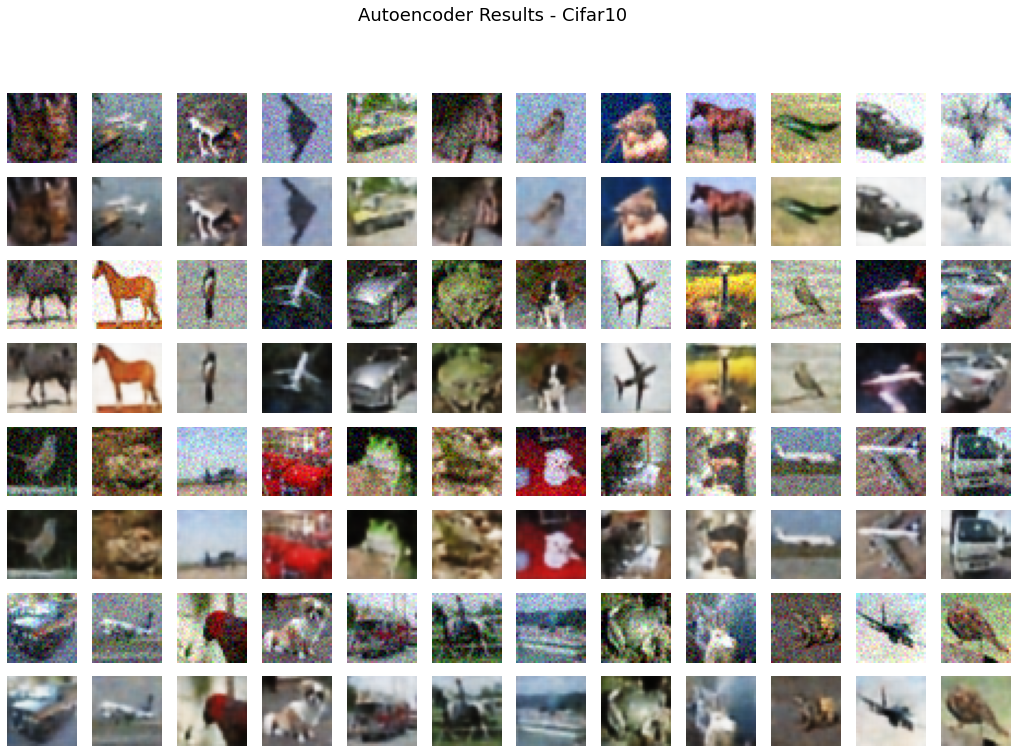

In [10]:
#####################################################################################
# Visualize test images with their denoised images

rows = 4 # defining no. of rows in figure
cols = 12 # defining no. of colums in figure
cell_size = 1.5
f = plt.figure(figsize=(cell_size*cols,cell_size*rows*2)) # defining a figure 
f.tight_layout()
for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_images[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_test_desoided[i*cols + j]) 
        plt.axis("off")

f.suptitle("Autoencoder Results - Cifar10",fontsize=18)
plt.savefig("test_results_cifar10.png")

plt.show()